# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах 
двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**схема пластины для варианта 1**

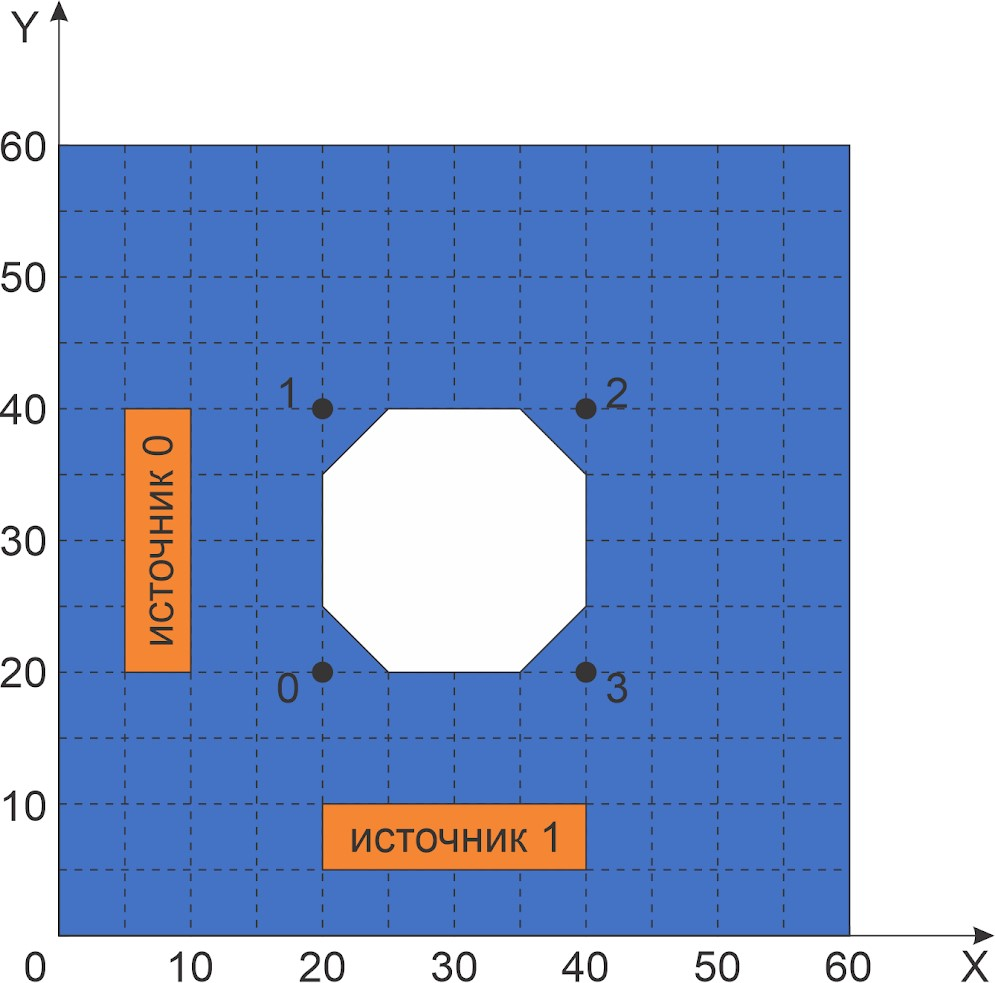


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


# Библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from datetime import datetime
from scipy.signal import find_peaks
import seaborn as sns

# Параметры и вспомогательные функции

### Граничные условия

Граничное условие в виде фиксированной температуры записывается в ячейки сетки, соответствующие ребрам прямоугольной области:

Например, для грани $x = 0$: $T^{n}_{0,j} = T_*$, грани $x = L$: $T^{n}_{N-1,j} = T_*$. 


Граничное условие в виде абсолютной теплоизоляции означает, что через заданную грань нет потока тепла, а это достижимо, если температура в ячейках грани и прилегающим к ним ячейкам одинаковая:

Например, $x = 0$: $T^{n}_{0,j} = T^{n}_{1,j}$, грани $x = L$: $T^{n}_{N-1,j} = T^{n}_{N-2,j}$.

In [2]:
def conditions(T: np.ndarray):
    '''
    на вход принимаемся массив температур и задаются граничные условия
    возвращаются значения темперавтур при соблюдении условий теплоизоляции и фиксированной температуры
    '''
    # фиксированная температура на ребрах х = 0 и у = 0
    T[:,:,0] = 0
    T[:,0,:] = 0
    # абсолютная теплоизоляция
    T[:,-1,:] = T[:,-2,:]
    T[:,:,-1] = T[:,:,-2]

### Источники тепла

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$

In [3]:
def heat_source(T: np.ndarray, 
                x: int,
                y: int,
                h: int,
                w: int,
                p: int,
                th: int,
                it: int,
                dt: float
               ):
    '''
    Принимает на вход значения температур, местоположение источника тепла(координаты их левых нижних точек и высоты и длины)
    параметры источников тепла 
    итерацию и деление времени
    Врзвращает температуру после совершения шага иттерации
    '''
    T[:, y:y+h, x:x+w] += p*(np.sin(2*np.pi/th*it*dt)+1)*dt

### Рекурентная формула вычисления температуры

рекуррентная формула для вычисления температуры в момент времени $n \cdot dt$ в ячейке сетки $(i, j)$ на основании данных в момент времени $(n-1) \cdot dt$:

$T^{n}_{i,j} = T^{n-1}_{i,j} + \frac{dt D_{i,j}}{dx^2} \left(T^{n-1}_{i-1,j} + T^{n-1}_{i+1,j} + T^{n-1}_{i,j-1}  + T^{n-1}_{i,j+1} - 4T^{n-1}_{i,j}\right) + \frac{dt}{c_p \rho} \cdot \dot{q}^{n}_{i,j}$

In [4]:
def diffuse_step_full(
    it: int,
    T: np.ndarray,
    dx: float,
    dt: float,
    d: np.ndarray
):
    '''
    Принимает на вход номер итерации, матрицу температур,
    шаг разбиения, разбиение времени, и матрицу коэффициентов диффузии
    Возвращает матрицу температур после совершения перехода в момент времени n*dt
    '''
    prev = it % 2
    cur = prev - 1

    T[cur,1:-1,1:-1] = T[prev, 1:-1, 1:-1] + dt *  d[1:-1, 1:-1] * dx**2 *(
         T[prev, 1:-1,0:-2] + T[prev, 1:-1, 2: ] + T[prev, 0:-2, 1:-1] + T[prev, 2:,   1:-1] - 
             4 * T[prev, 1:-1, 1:-1])

Временной шаг $dt$ должен быть таким, чтобы учитывать условие Курранта: $dt \leq \frac{C \cdot dx^2}{D_{max}}$, где $C$ - число Курранта.

### Задание матрицы коэффициентов диффузии

In [5]:
def diff_mat(dx: float, d0: float,d1: float):

    '''
    принимает на вход dx - разбиение
    и коэффициенты диффузии двух материалов
    возвращает матрицу коэффициентов диффузии соответствующую 
    расположению материалов

    '''
    d_arr = np.full((n, n), d_0) # массив диффузии

    # вставка белого материала

    d_arr[20*dx:40*dx, 25*dx:35*dx] = d_1
    d_arr[25*dx:35*dx, 20*dx:40*dx] = d_1

    for i in range(20*dx,25*dx):
        d_arr[35*dx:dx*15+i, i ] = d_1

    for i in range(5*dx):
        d_arr[20*dx + i:25*dx,i+35*dx] = d_1

    for i in range(5*dx):
        d_arr[25*dx-i:25*dx,i+20*dx] = d_1

    for i in range(5*dx):
        d_arr[35*dx:40*dx-i,i+35*dx] = d_1
        
    return d_arr
    

### Задание положения проб

In [6]:
def probs(dx: int):
    '''
    функция принимает на вход значение dx
    и возврацает местоположение проб соответствующим данному разбиению
    '''
    pr = np.zeros((4,2))
    pr[0][0] = int(20 * dx)
    pr[0][1] = int(20 * dx)
    pr[1][0] = int(20 * dx)
    pr[1][1] = int(40 * dx)
    pr[2][0] = int(40 * dx)
    pr[2][1] = int(40 * dx)
    pr[3][0] = int(40 * dx)
    pr[3][1] = int(20 * dx)
    return pr
    

### Постоянные

In [7]:
l = 60 # длина и ширина пластины
t_max = 600 # время моделирования 
C = 0.2 # постоянная Куранта

d_0 = 1.0 # коэффициент диффузии материала синего цвета
d_1 = 0.01 # коэффициент диффузии материала белого цвета

N = [60, 120, 240, 480, 960] #количество делений на пластине 

p_0 = 100   # параметры источника 0
theta_0 = 43

p_1 = 100    # параметры источника 1
theta_1 = 77

# Вычисление 

In [8]:
for n in N:

    time = datetime.now()  # начала замера времени
    dx = int(n/l)  # шаг выполнения
    dt = C  /dx**2 / d_0 #шаг по времени, с
    it_max = int(t_max / dt)  # количество итераций
    d_arr = diff_mat(dx, d_0, d_1) # массив коэффициентов диффузии

    # параметры источников

    heat_x_0 = 5*dx
    heat_y_0 = 20*dx
    heat_h_0 = 20*dx
    heat_w_0 = 5*dx

    heat_x_1 = 20*dx
    heat_y_1 = 5*dx
    heat_h_1 = 5*dx
    heat_w_1 = 20*dx

    # массив температур
    T = np.zeros((2,n,n))

    pr = probs(dx) # массив местоположения проб

    # массивы для сохранения данных на пробе
    probe_values_0 = []
    probe_values_1 = []
    probe_values_2 = []
    probe_values_3 = []

    for it in trange(it_max):
        heat_source(T, heat_x_0, heat_y_0, heat_h_0, heat_w_0, p_0, theta_0, it, dt)
        heat_source(T, heat_x_1, heat_y_1, heat_h_1, heat_w_1, p_1, theta_1, it, dt)
        conditions(T)
        diffuse_step_full(it, T, dx, dt, d_arr)

        # добавление данных к массиву
        probe_values_0.append(T[it % 2 - 1, int(pr[0][0]), int(pr[0][1])])
        probe_values_1.append(T[it % 2 - 1, int(pr[1][0]), int(pr[1][1])])
        probe_values_2.append(T[it % 2 - 1, int(pr[2][0]), int(pr[2][1])])
        probe_values_3.append(T[it % 2 - 1, int(pr[3][0]), int(pr[3][1])])

    # сохранение данных из масссивов
    np.save("T_"+ str(n), T[0])
    np.save("pr0_"+ str(n), probe_values_0)
    np.save("pr1_"+ str(n), probe_values_1)
    np.save("pr2_"+ str(n), probe_values_2)
    np.save("pr3_"+ str(n), probe_values_3)
# вывод времени замера
    print("n = ", n, "time = " , datetime.now() - time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 6133.11it/s]


n =  60 time =  0:00:00.545916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:02<00:00, 4194.71it/s]


n =  120 time =  0:00:02.882358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48000/48000 [00:40<00:00, 1192.73it/s]


n =  240 time =  0:00:40.273937


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192000/192000 [36:09<00:00, 88.50it/s]


n =  480 time =  0:36:09.632073


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768000/768000 [9:41:02<00:00, 22.03it/s]


n =  960 time =  9:41:02.614652


# Построение изображения матрицы коэффициентов диффузии

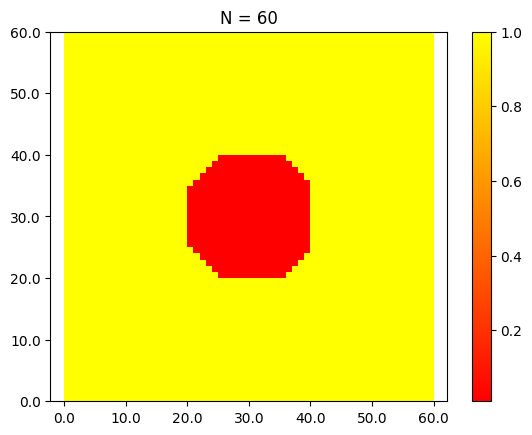

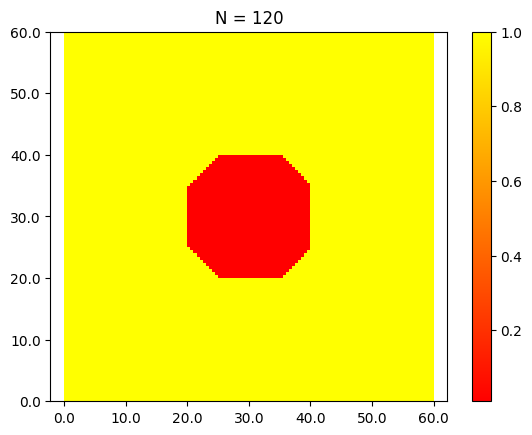

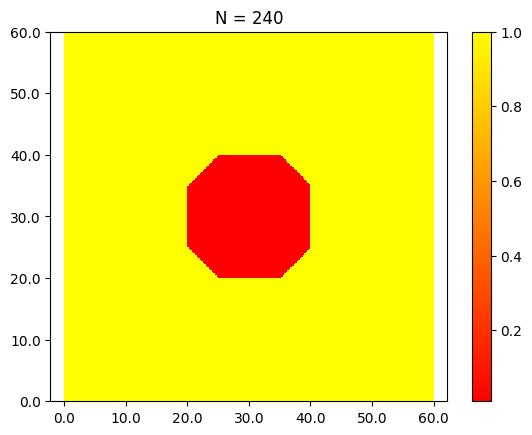

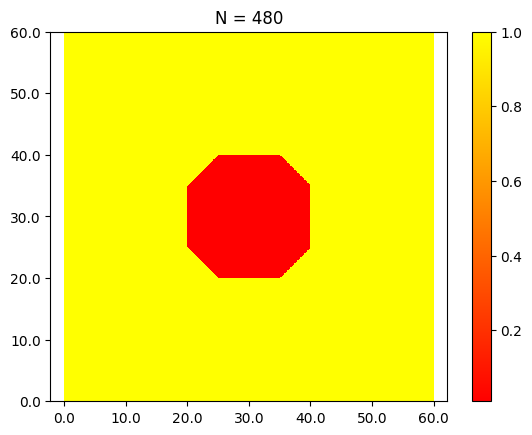

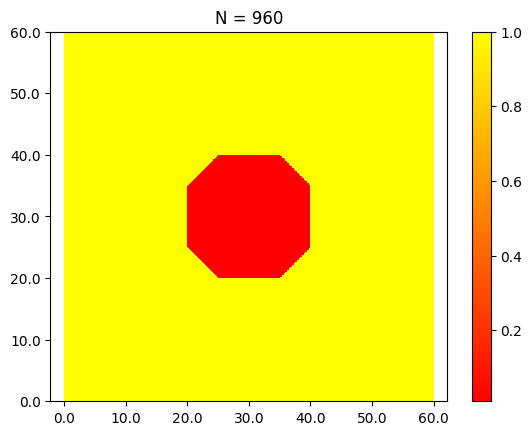

In [9]:
for n in N:
    dx = int(n/l)
    
    d_arr = diff_mat(dx, d_0, d_1)
        
    plt.pcolormesh(d_arr, cmap = 'autumn')
    plt.axis('equal')  
    plt.title('N = '+ str(n))
    plt.xticks(np.linspace(0,n,7),np.linspace(0,60,7))
    plt.yticks(np.linspace(0,n,7),np.linspace(0,60,7))
    plt.colorbar()
    plt.show()

# Цветовая карта поля температур в конечный момент времени

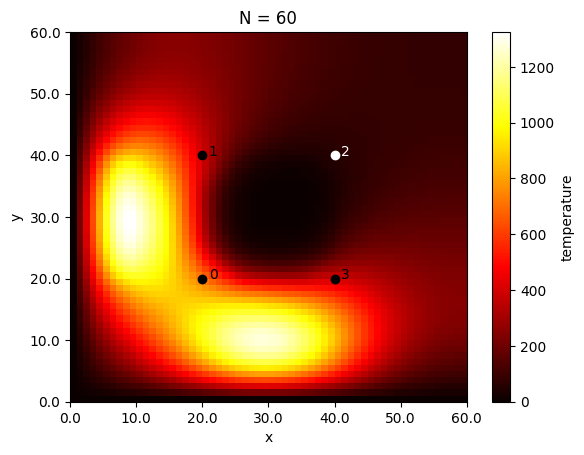

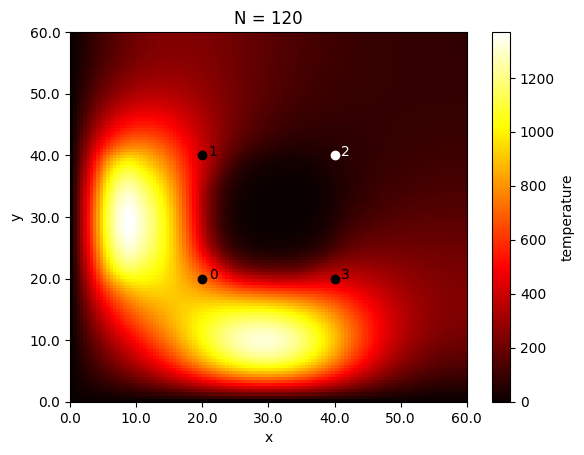

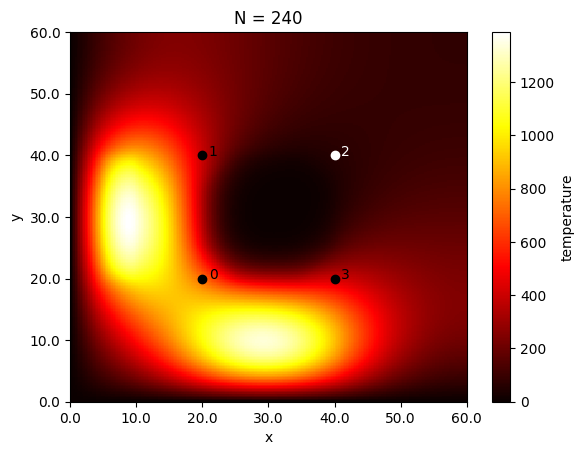

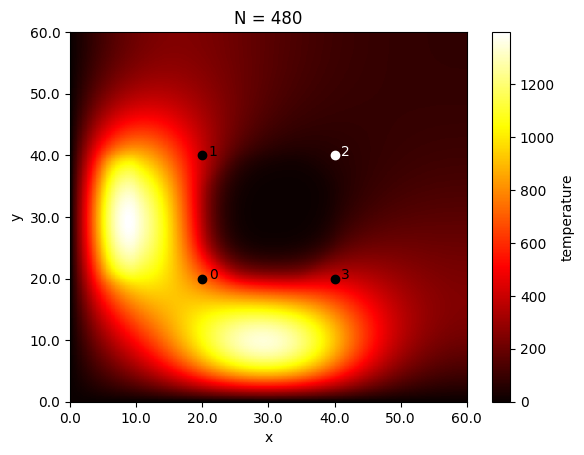

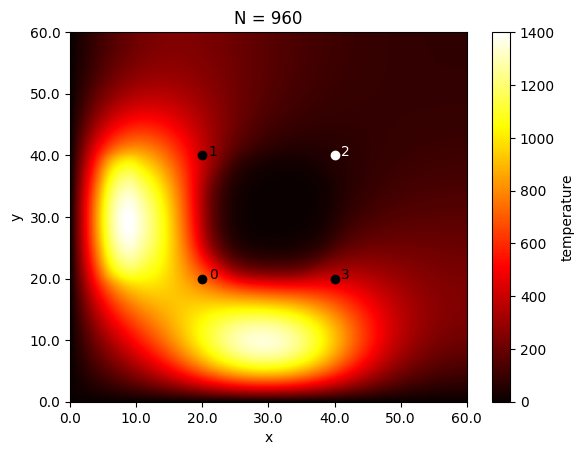

In [10]:
for n in N:
    dx = int(n/l)
    dt = C  /dx**2 / d_0 #шаг по времени, с

    #пробы
    pr = probs(dx)

    T_ = np.load('T_{}.npy'.format(n))

    #график распределения температур
    plt.pcolormesh(T_, cmap='hot')
    plt.colorbar().set_label(label='temperature')
    plt.title('N = '+ str(n))
    plt.plot(pr[0][0], pr[0][1], 'ok')
    plt.text(pr[0][0]+dx, pr[0][1],'0', color='k')
    plt.plot(pr[1][0], pr[1][1], 'ok')
    plt.text(pr[1][0]+dx, pr[1][1],'1', color='k')
    plt.plot(pr[2][0], pr[2][1], 'ow')
    plt.text(pr[2][0]+dx, pr[2][1],'2', color='w')
    plt.plot(pr[3][0], pr[3][1], 'ok')
    plt.text(pr[3][0]+dx, pr[3][1],'3', color='k')
    plt.xticks(np.linspace(0,n,7),np.linspace(0,60,7))
    plt.yticks(np.linspace(0,n,7),np.linspace(0,60,7))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Графики температур в местах установки проб

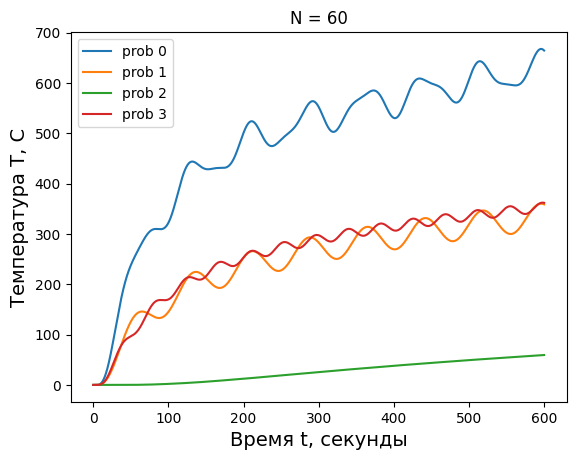

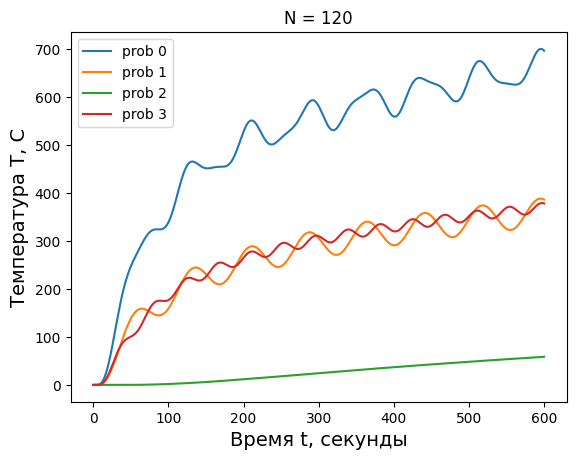

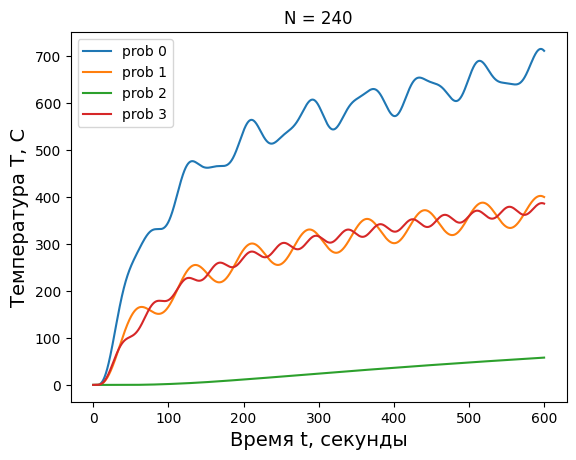

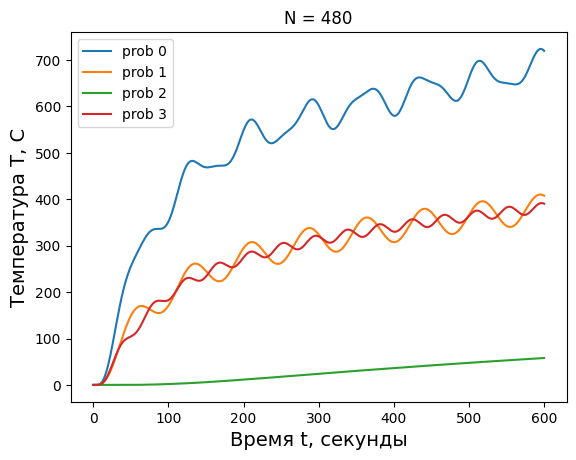

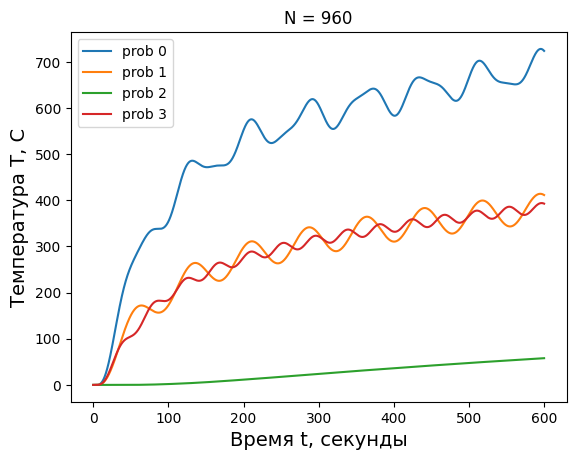

In [11]:
for n in N:
    dx = int(n/l)
    dt = C  /dx**2 / d_0 #шаг по времени, с
    for i in range(4):
        pr = np.load('pr{}_{}.npy'.format(i, n))
        plt.plot(np.linspace(0, t_max, np.size(pr)), pr, label='prob {}'.format(i))
    plt.xlabel("Время t, секунды", fontsize= 14)
    plt.ylabel("Температура T, С", fontsize= 14);
    plt.title('N = {}'.format(n))
    plt.legend()
    plt.show()

#  Восстановление периодов колебаний температуры

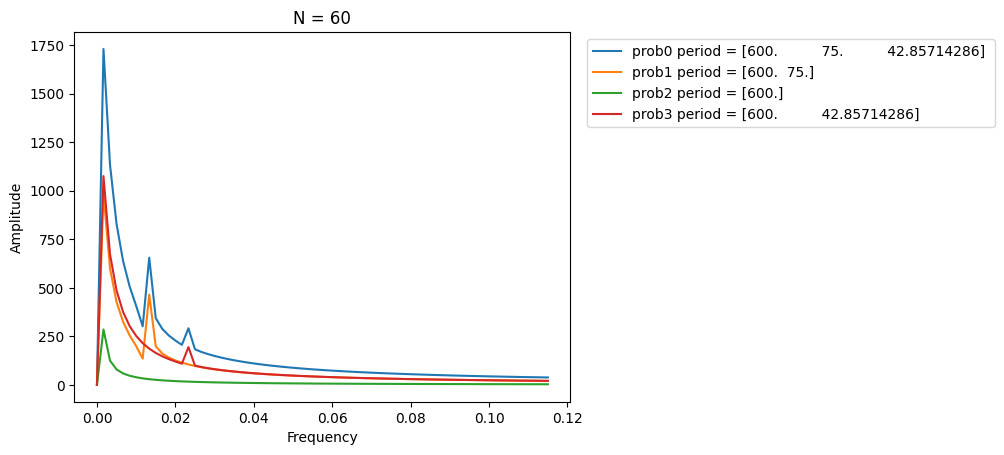

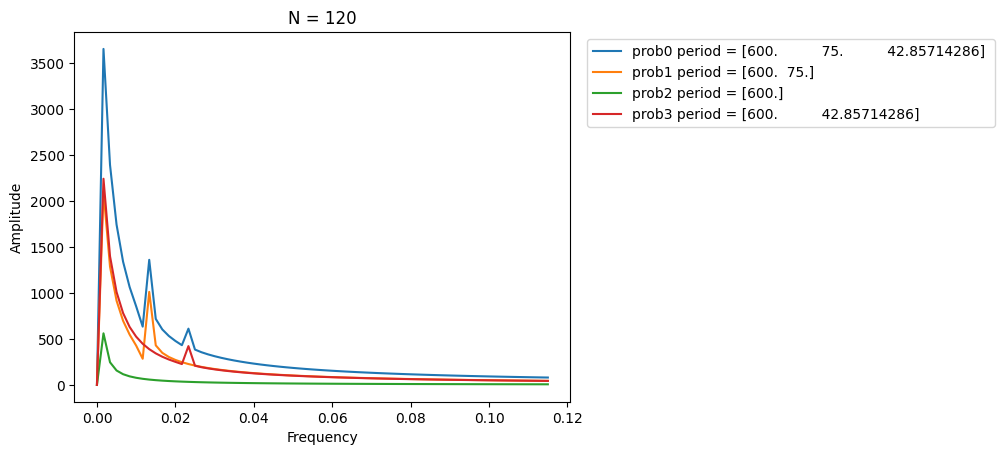

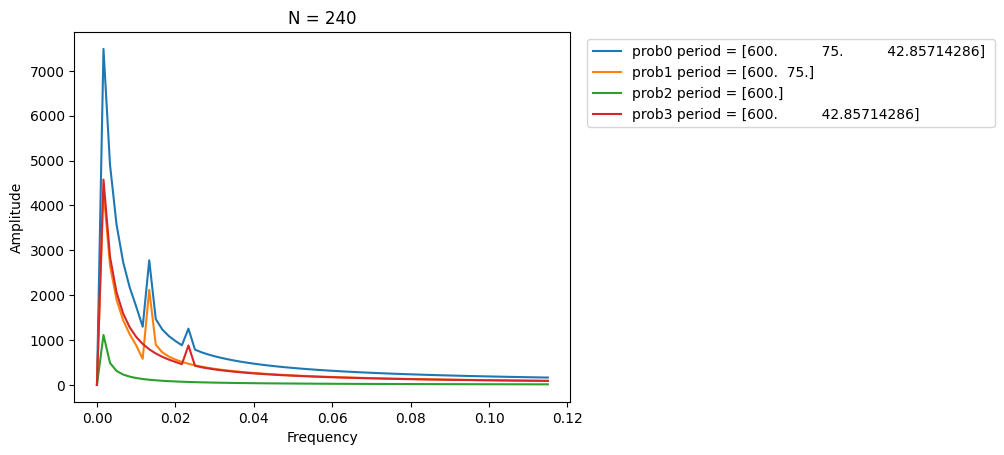

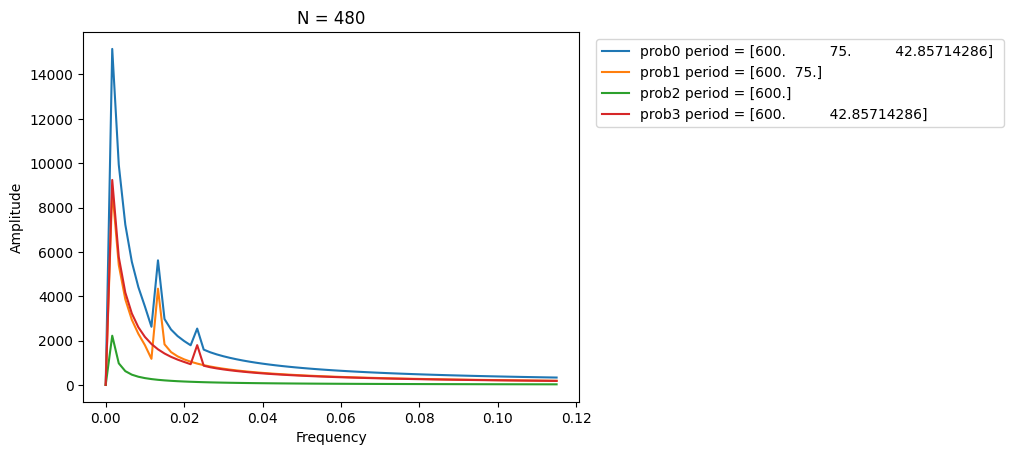

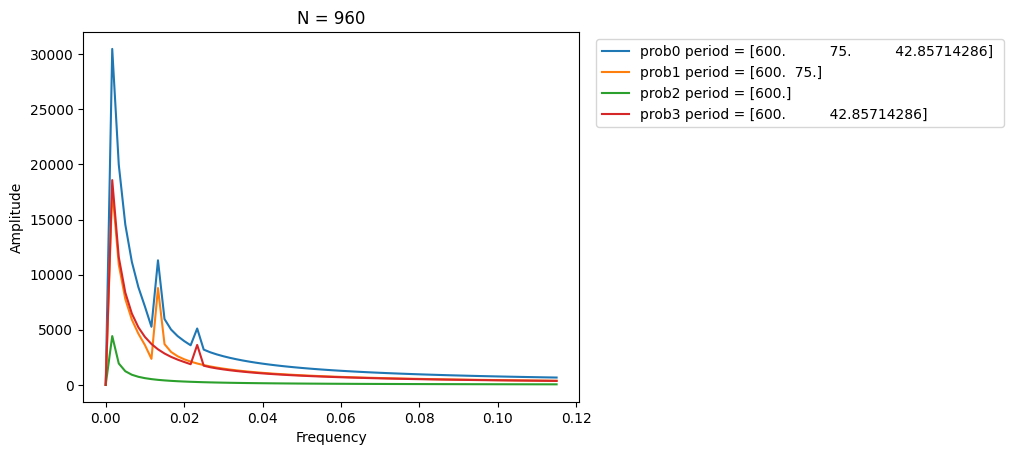

In [12]:
for n in N:
    dx = int(n/l)
    dt = C  /dx**2 / d_0
    for i in range(4):
        pr = np.load('pr{}_{}.npy'.format(i, n))
        amp = np.abs(np.fft.rfft(pr-pr.mean()))/n/2
        freq = np.fft.rfftfreq(len(pr), dt)
        ind = find_peaks(amp)[0]
        period = 1/freq[ind]
        plt.plot(freq[0:70],amp[0:70],label='prob{} period = {} '.format(i, period))
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('N = {}'.format(n))
    plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left')
    plt.show()